In [28]:
import os
import pandas as pd
fileAirPath = './image/'

airPic = os.listdir(fileAirPath)
airPic.sort()

data = pd.read_csv('./amos0313_last.csv')
def getlabel(date):
#     比如030200，代表3点2分
    hour = int(date[:2])
    minute = int(date[2:4])
    
    idNum = hour * 60 + minute + 959
#     print(idNum)
    try:
        label = data.at[idNum, 'MOR']
#         print(label)
    except:
        print(hour, minute, idNum)
        
    return label

# 这里的trianx和y 没有按照时间顺序来
# 
trainY = np.array([getlabel(time[:6]) for time in airPic], dtype=np.float32)


In [38]:
depth = []
with open('./airDepth', 'r') as file:
    for line in file:
        line = line.strip()
        depth.append(float(line))

depth = np.array(depth, dtype=np.float32)
depthNew = (depth - depth.min()) * 100 / (depth.max() - depth.min())

trainYNew = (trainY - trainY.min()) * 100 / (trainY.max() - trainY.min())




In [39]:
len(depth)

466

In [40]:
trainY.shape

(466,)

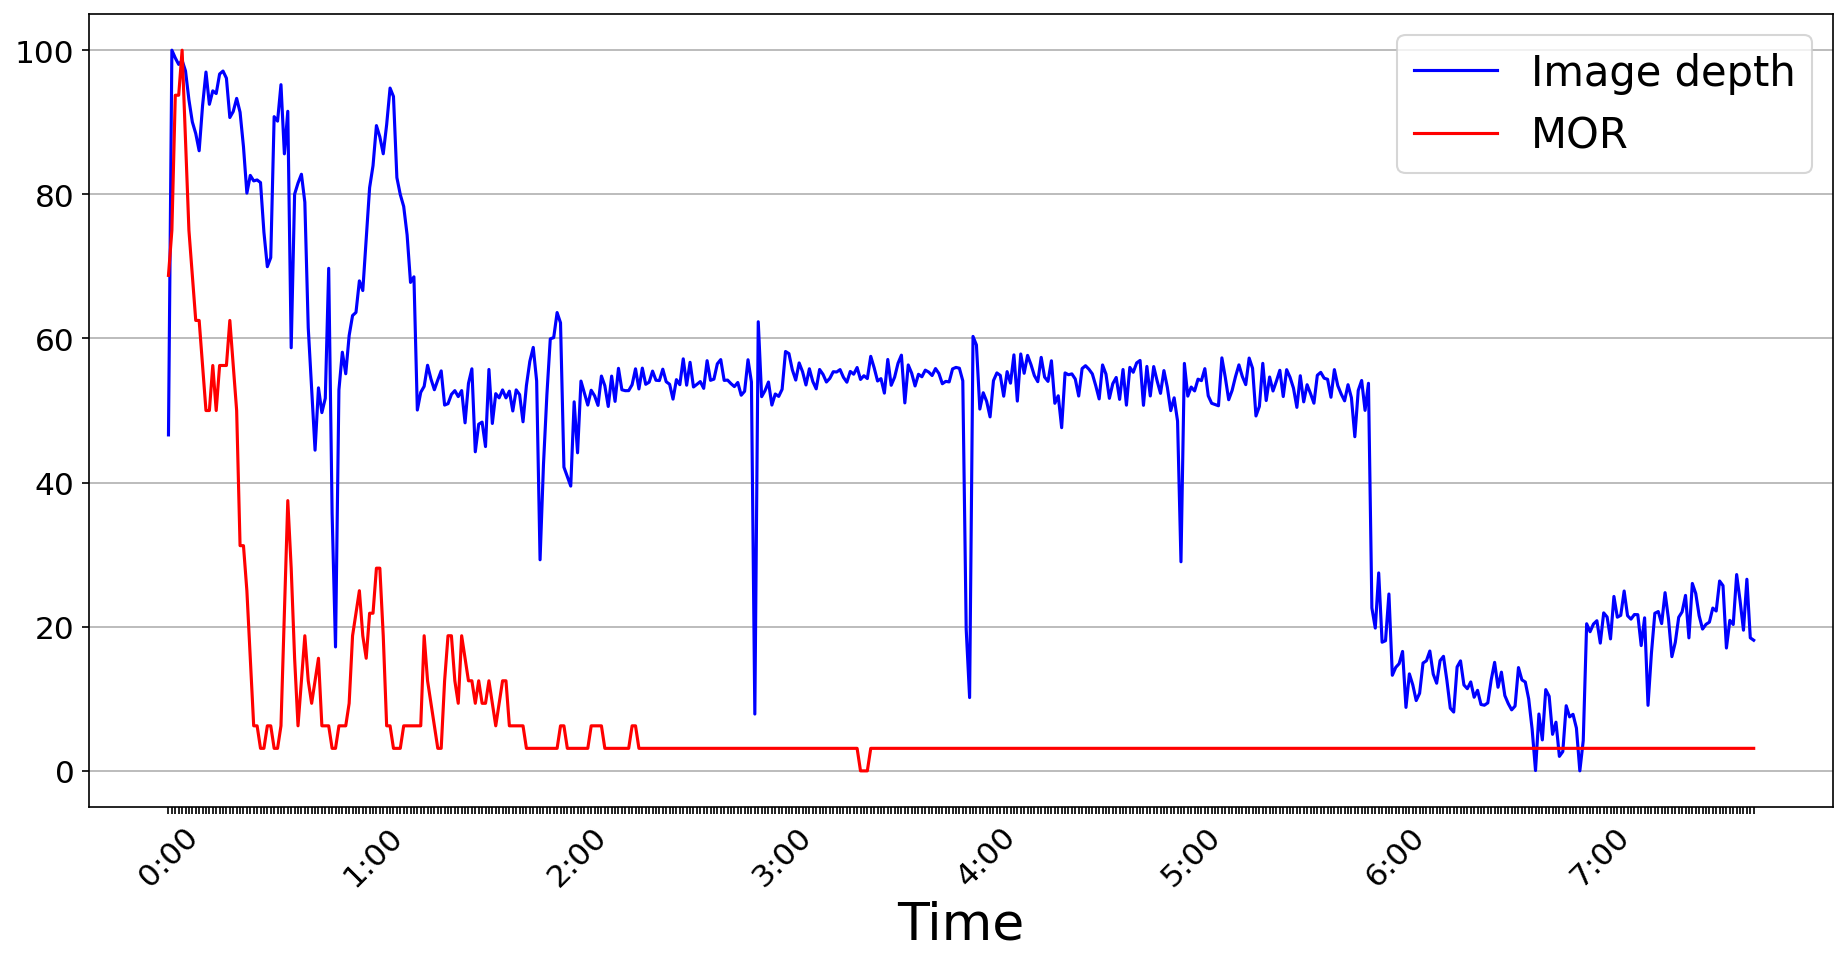

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7), dpi=150)


temp = []
for i in range(24):
    for j in range(60):
        if j == 0:
            date = str(i) + ":0" + str(j)
        else:
#             date = str(i) + ":" + str(j)
            date = ""
        temp.append(date)
datetime = temp[:466]

plt.plot(depthNew, label='Image depth', color='blue')
plt.plot(trainYNew, label='MOR', color='red')

plt.xticks(np.arange(len(datetime)), datetime, rotation = 45)
plt.tick_params(labelsize=15)
plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=25)
# plt.ylabel("",fontsize=25)
plt.grid(which='major', axis='y')
plt.savefig('./mor_depth.jpg',bbox_inches='tight')



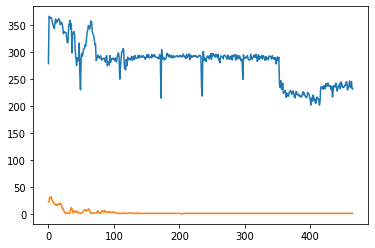

In [43]:
plt.plot(depth)
plt.plot(trainY)

p1 is :
            3           2
2.146e-05 x - 0.01705 x + 4.487 x - 389.3


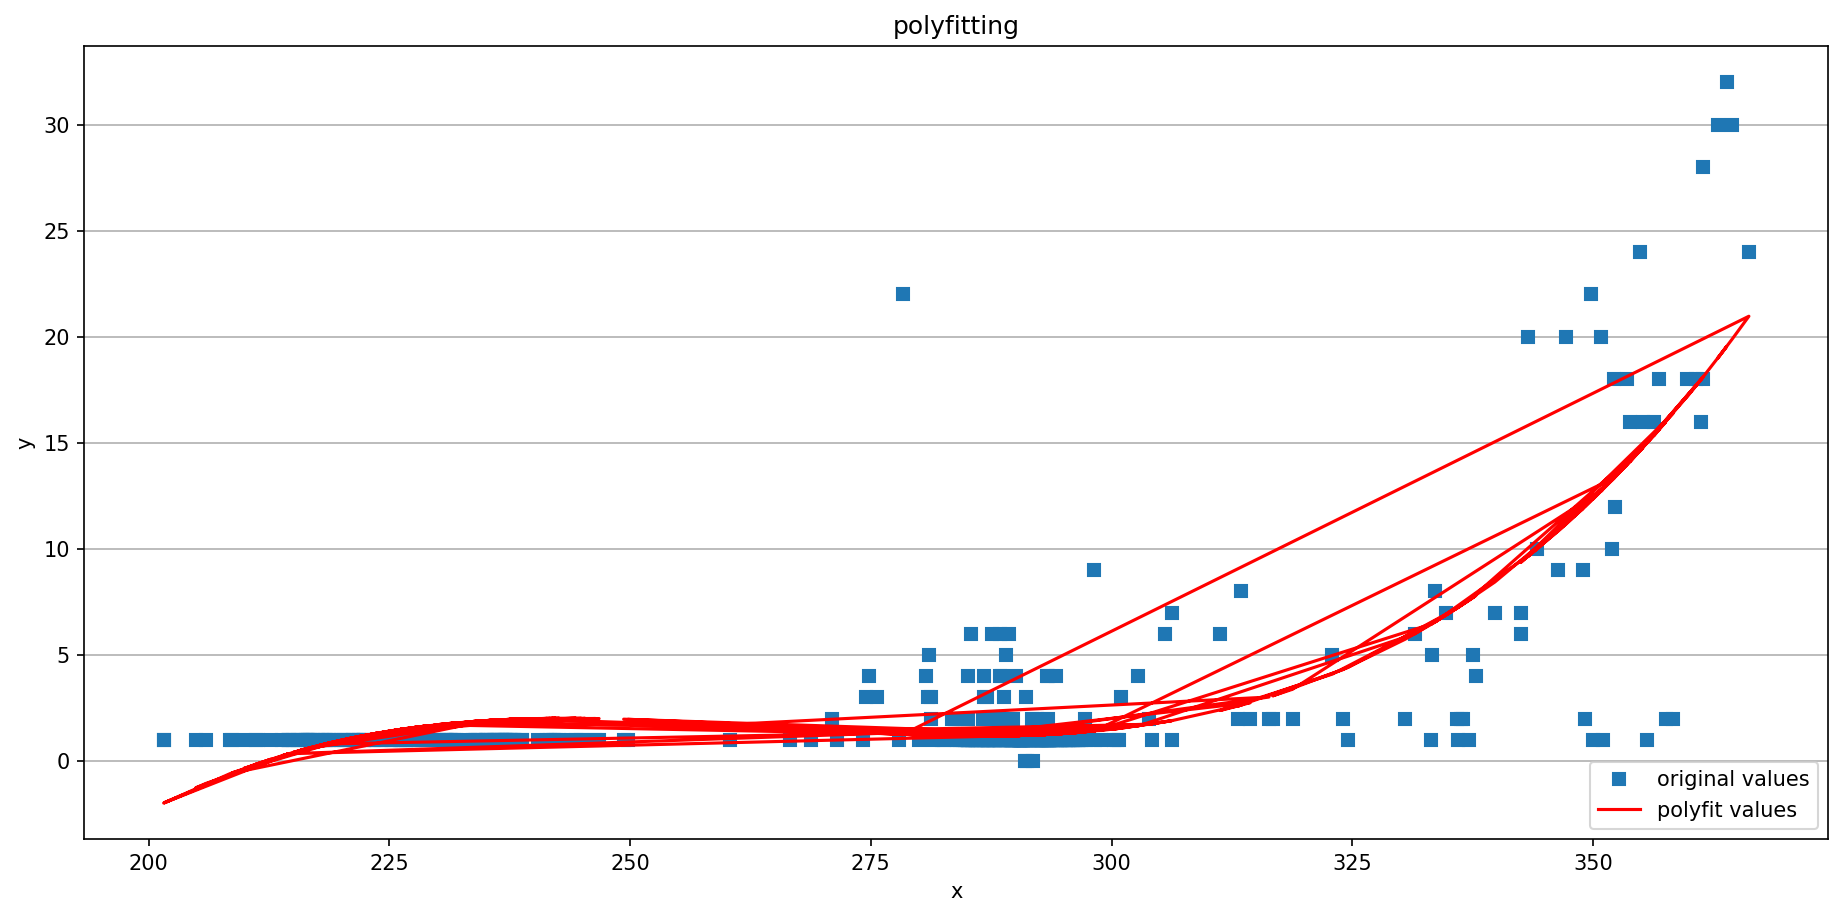

In [57]:
# x = np.array(da['QFE R06 (HPA)'].to_list())
# y = np.array(da['MOR'].to_list())

x = depth
y = trainY
f1 = np.polyfit(x, y, 3)
p1 = np.poly1d(f1)

print('p1 is :\n',p1)

yvals = p1(x)
plt.figure(figsize=(15,7), dpi=150)

plot1 = plt.plot(x, y, 's', label='original values')
plot2 = plt.plot(x, yvals, 'r',label='polyfit values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=4) #指定legend的位置右下角
plt.grid(which='major', axis='y')

plt.title('polyfitting')
plt.show()

In [64]:
def get(x):
    return 2.146e-05*x**3 - 0.01705*x**2 + 4.487*x -389.3

In [65]:
pred = []

for i in depth:
    pred.append(get(i))
    

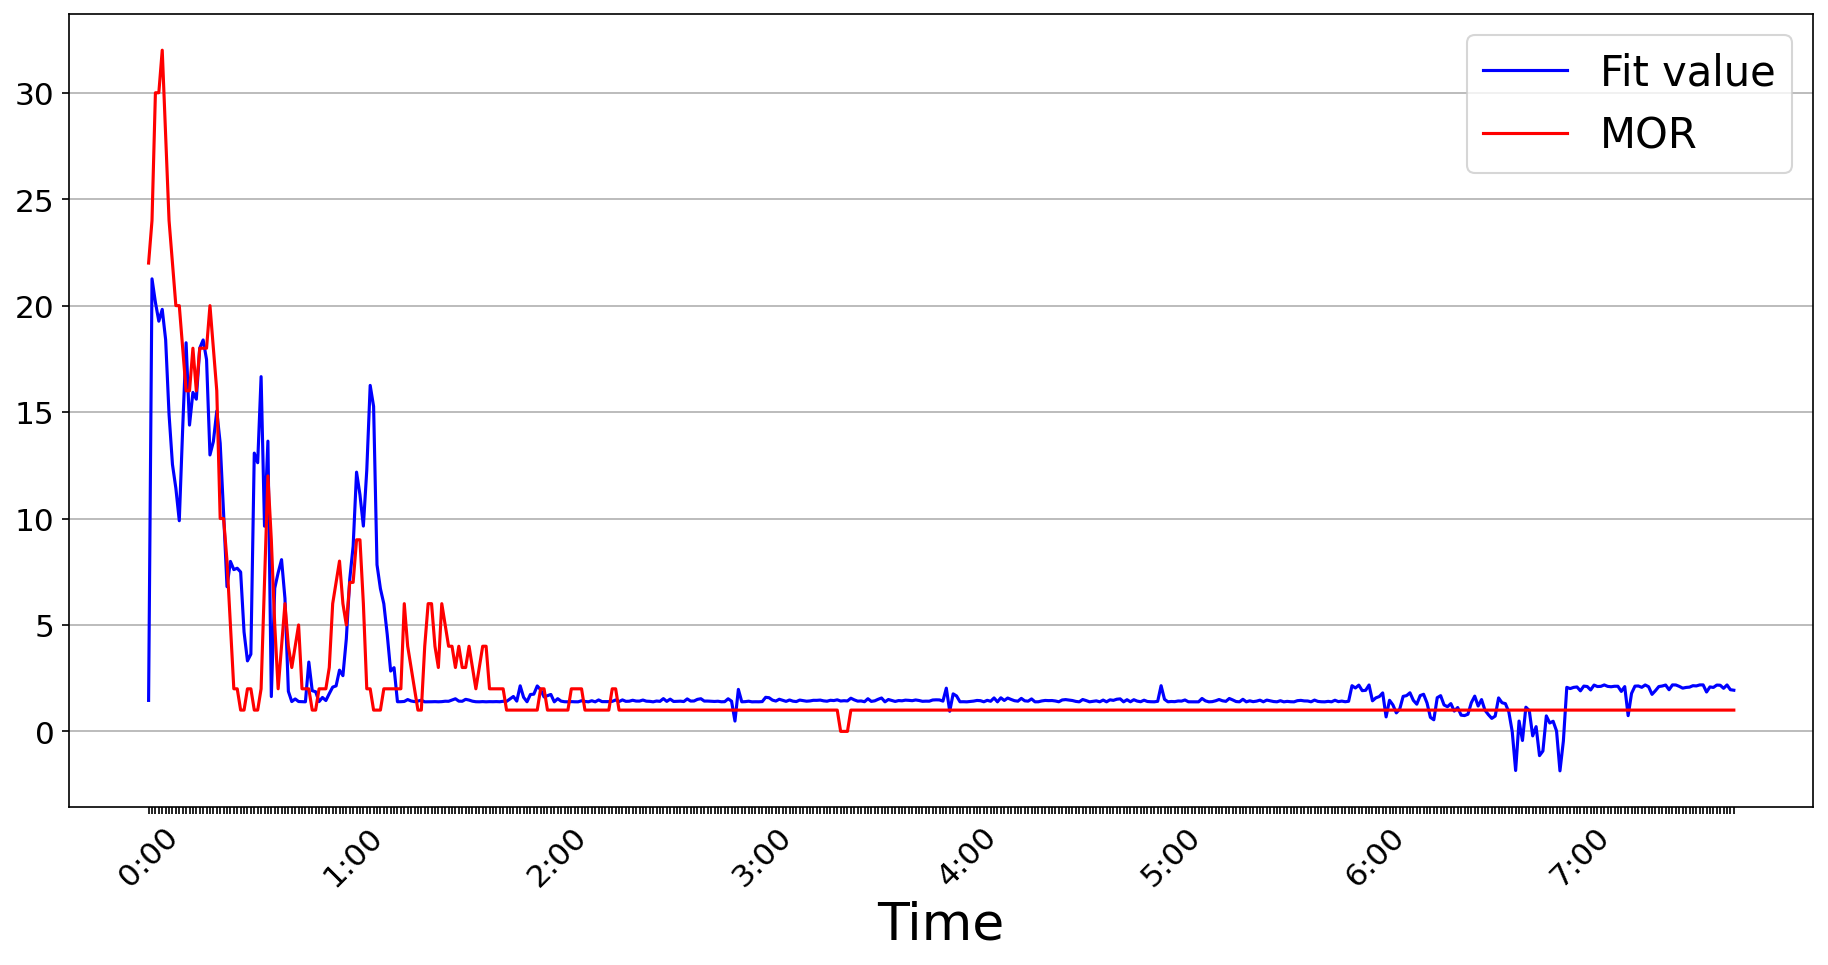

In [68]:


plt.figure(figsize=(15,7), dpi=150)

plt.plot(pred, label='Fit value', color='blue')
plt.plot(trainY, label='MOR', color='red')

plt.xticks(np.arange(len(datetime)), datetime, rotation = 45)
plt.tick_params(labelsize=15)
plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=25)
# plt.ylabel("",fontsize=25)
plt.grid(which='major', axis='y')
plt.savefig('./mor_depth.jpg',bbox_inches='tight')

In [86]:
rdepth = []
with open('./roadDepth', 'r') as file:
    for line in file:
        line = line.strip()
        rdepth.append(float(line))
pred = []

for i in rdepth:
    pred.append(get(i)*50 - 60)
pred = np.array(pred)


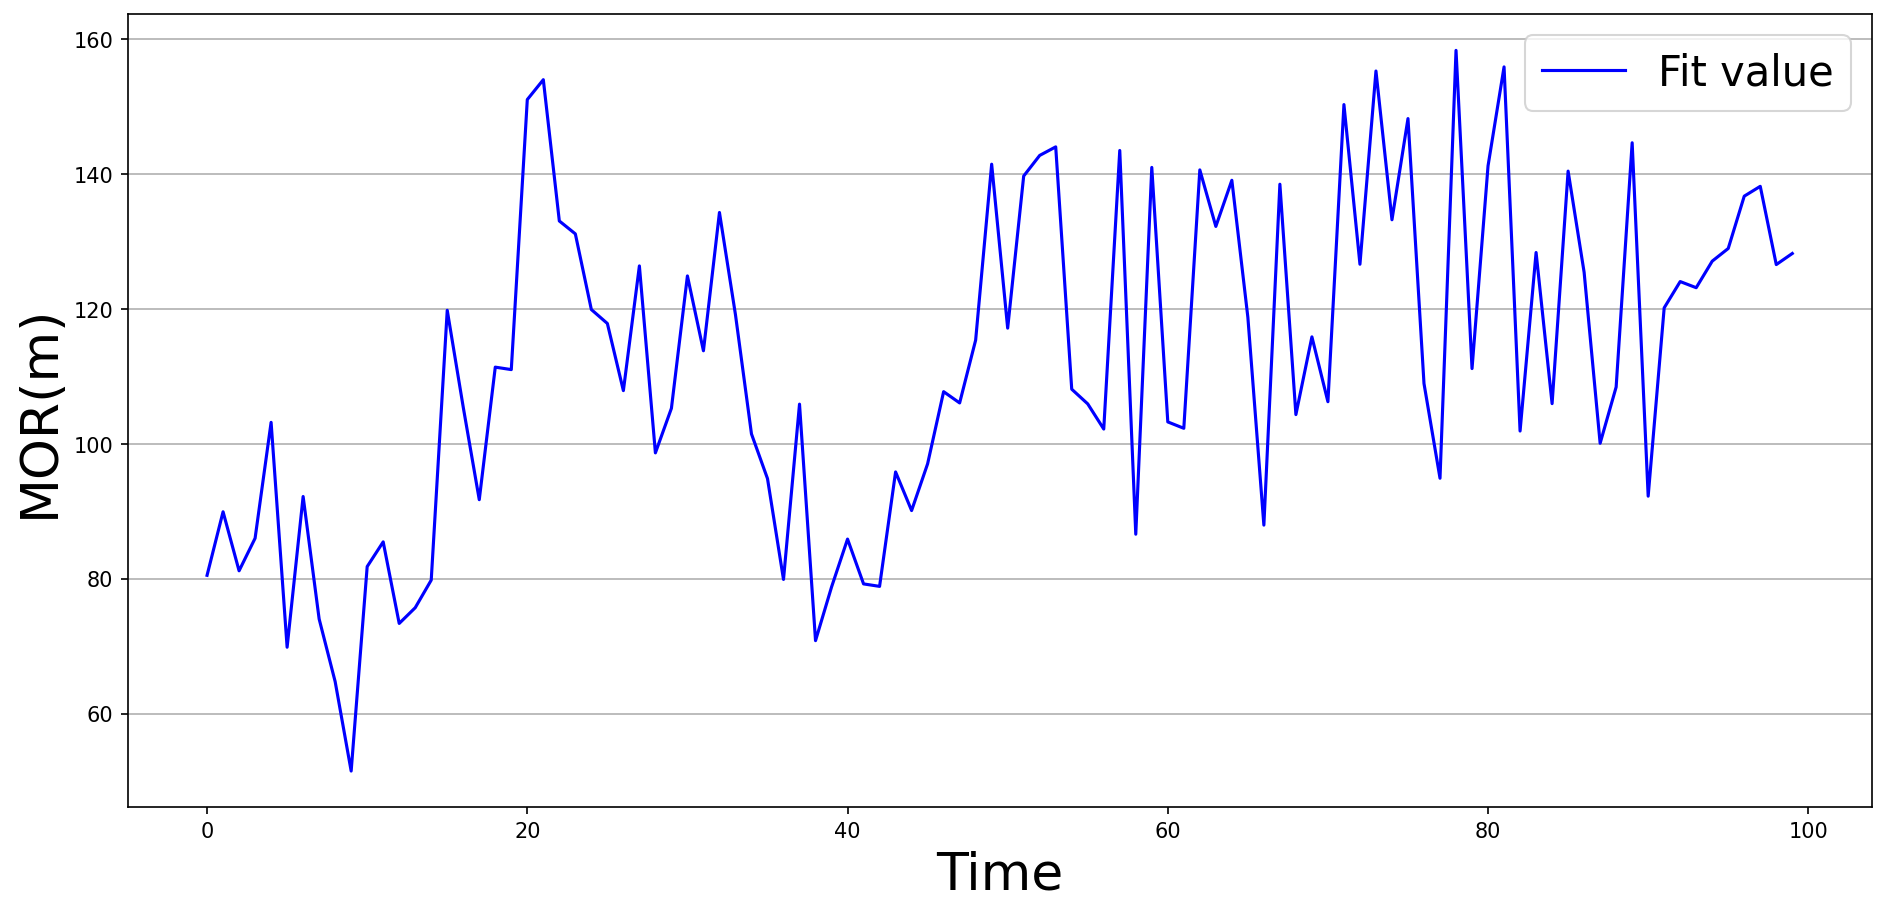

In [81]:


plt.figure(figsize=(15,7), dpi=150)

plt.plot(pred, label='Fit value', color='blue')

# plt.xticks(np.arange(len(datetime)), datetime, rotation = 45)
# plt.tick_params(labelsize=15)
plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=25)
plt.ylabel("MOR(m)",fontsize=25)

# plt.ylabel("",fontsize=25)
plt.grid(which='major', axis='y')
plt.savefig('./road_mor_fit.jpg',bbox_inches='tight')

In [85]:
pred = np.array(pred)
pred.mean(), pred.min(), pred.max()

(111.99638171217366, 51.51597022280555, 158.31012458643215)

In [110]:
diff = 4

pred_avg = []
for i in range(int(len(pred) / diff)):
    a = 0
    for j in range(diff):
        a += pred[i * diff + j]
    
    pred_avg.append(a / diff)
    
len(pred_avg)


25

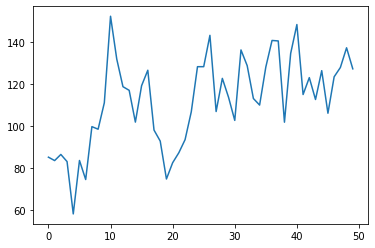

In [109]:
plt.plot(pred_avg)

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense, LSTM, GRU, BatchNormalization, LayerNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

gru = GRU(256, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')


In [173]:
rdepth = []
with open('./roadDepth', 'r') as file:
    for line in file:
        line = line.strip()
        rdepth.append(float(line))
pred = []

for i in rdepth:
    pred.append(get(i)*50 - 60)
# pred = np.array(pred)

# pred.shape

trainX = []
trainY = []
diff = 5
for i in range(len(pred) - 1 - diff):
    da = []
    for j in range(diff):
        da.append(pred[i + j])
    
    trainX.append(da)
    trainY.append(pred[i + diff])

trainX = np.array(trainX, dtype=np.float32)
trainX = np.reshape(trainX, (94, 5, 1))
trainY = np.array(trainY, dtype=np.float32)

    
    
class StockModel(Model):
    def __init__(self):
        super(StockModel, self).__init__()
        # 不是最后一层return_sequences需要为true，给下一层
        self.L1 = GRU(512, activation='relu', return_sequences=True, unroll=True)
        self.L2 = GRU(256, activation='relu', return_sequences=False, unroll=True)

#         self.b2 = LayerNormalization()
        self.d1 = Dropout(0.2)
        self.f1 = Dense(1)
    
    def call(self, x):
        return self.f1(self.d1((self.L2(self.L1(x)))))

model = StockModel()

model.compile(optimizer='adam',
              loss='mean_squared_error')

    
# model = timeSeries()
# model.compile(optimizer='adam', 
#               loss = 'mean_squared_error'
#             )

history = model.fit(x=trainX, y=trainY, epochs=200)


Train on 94 samples
Epoch 1/200
94/94 [==============================] - 9s 95ms/sample - loss: 12343.6308
Epoch 2/200
94/94 [==============================] - 0s 3ms/sample - loss: 7165.6429
Epoch 3/200
94/94 [==============================] - 0s 3ms/sample - loss: 1754.9739
Epoch 4/200
94/94 [==============================] - 0s 3ms/sample - loss: 1232.1065
Epoch 5/200
94/94 [==============================] - 0s 3ms/sample - loss: 698.4396
Epoch 6/200
94/94 [==============================] - 0s 3ms/sample - loss: 963.8776
Epoch 7/200
94/94 [==============================] - 0s 3ms/sample - loss: 580.3250
Epoch 8/200
94/94 [==============================] - 0s 3ms/sample - loss: 567.1378
Epoch 9/200
94/94 [==============================] - 0s 3ms/sample - loss: 545.8482
Epoch 10/200
94/94 [==============================] - 0s 3ms/sample - loss: 502.6241
Epoch 11/200
94/94 [==============================] - 0s 3ms/sample - loss: 571.2042
Epoch 12/200
94/94 [============================

94/94 [==============================] - 0s 3ms/sample - loss: 373.2233
Epoch 98/200
94/94 [==============================] - 0s 3ms/sample - loss: 452.2685
Epoch 99/200
94/94 [==============================] - 0s 2ms/sample - loss: 440.2349
Epoch 100/200
94/94 [==============================] - 0s 3ms/sample - loss: 523.8095
Epoch 101/200
94/94 [==============================] - 0s 3ms/sample - loss: 445.0118
Epoch 102/200
94/94 [==============================] - 0s 3ms/sample - loss: 377.2537
Epoch 103/200
94/94 [==============================] - 0s 3ms/sample - loss: 416.0742
Epoch 104/200
94/94 [==============================] - 0s 3ms/sample - loss: 410.1610
Epoch 105/200
94/94 [==============================] - 0s 3ms/sample - loss: 424.9207
Epoch 106/200
94/94 [==============================] - 0s 3ms/sample - loss: 384.9383
Epoch 107/200
94/94 [==============================] - 0s 3ms/sample - loss: 405.0551
Epoch 108/200
94/94 [==============================] - 0s 3ms/sample -

94/94 [==============================] - 0s 3ms/sample - loss: 430.1939
Epoch 193/200
94/94 [==============================] - 0s 3ms/sample - loss: 353.2019
Epoch 194/200
94/94 [==============================] - 0s 3ms/sample - loss: 355.2144
Epoch 195/200
94/94 [==============================] - 0s 3ms/sample - loss: 354.3805
Epoch 196/200
94/94 [==============================] - 0s 3ms/sample - loss: 324.3770
Epoch 197/200
94/94 [==============================] - 0s 3ms/sample - loss: 343.2265
Epoch 198/200
94/94 [==============================] - 0s 3ms/sample - loss: 336.9359
Epoch 199/200
94/94 [==============================] - 0s 3ms/sample - loss: 337.0494
Epoch 200/200
94/94 [==============================] - 0s 3ms/sample - loss: 288.6429


In [269]:
model.summary()

Model: "stock_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 multiple                  789504    
_________________________________________________________________
gru_14 (GRU)                 multiple                  590592    
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  257       
Total params: 1,380,353
Trainable params: 1,380,353
Non-trainable params: 0
_________________________________________________________________


In [232]:

predTest = []
for i in range(trainX.shape[0]):
    da = trainX[i,:,:]
    da = np.reshape(da, (1, 5, 1))
    predTest.append(model.predict(da)[0][0])
    


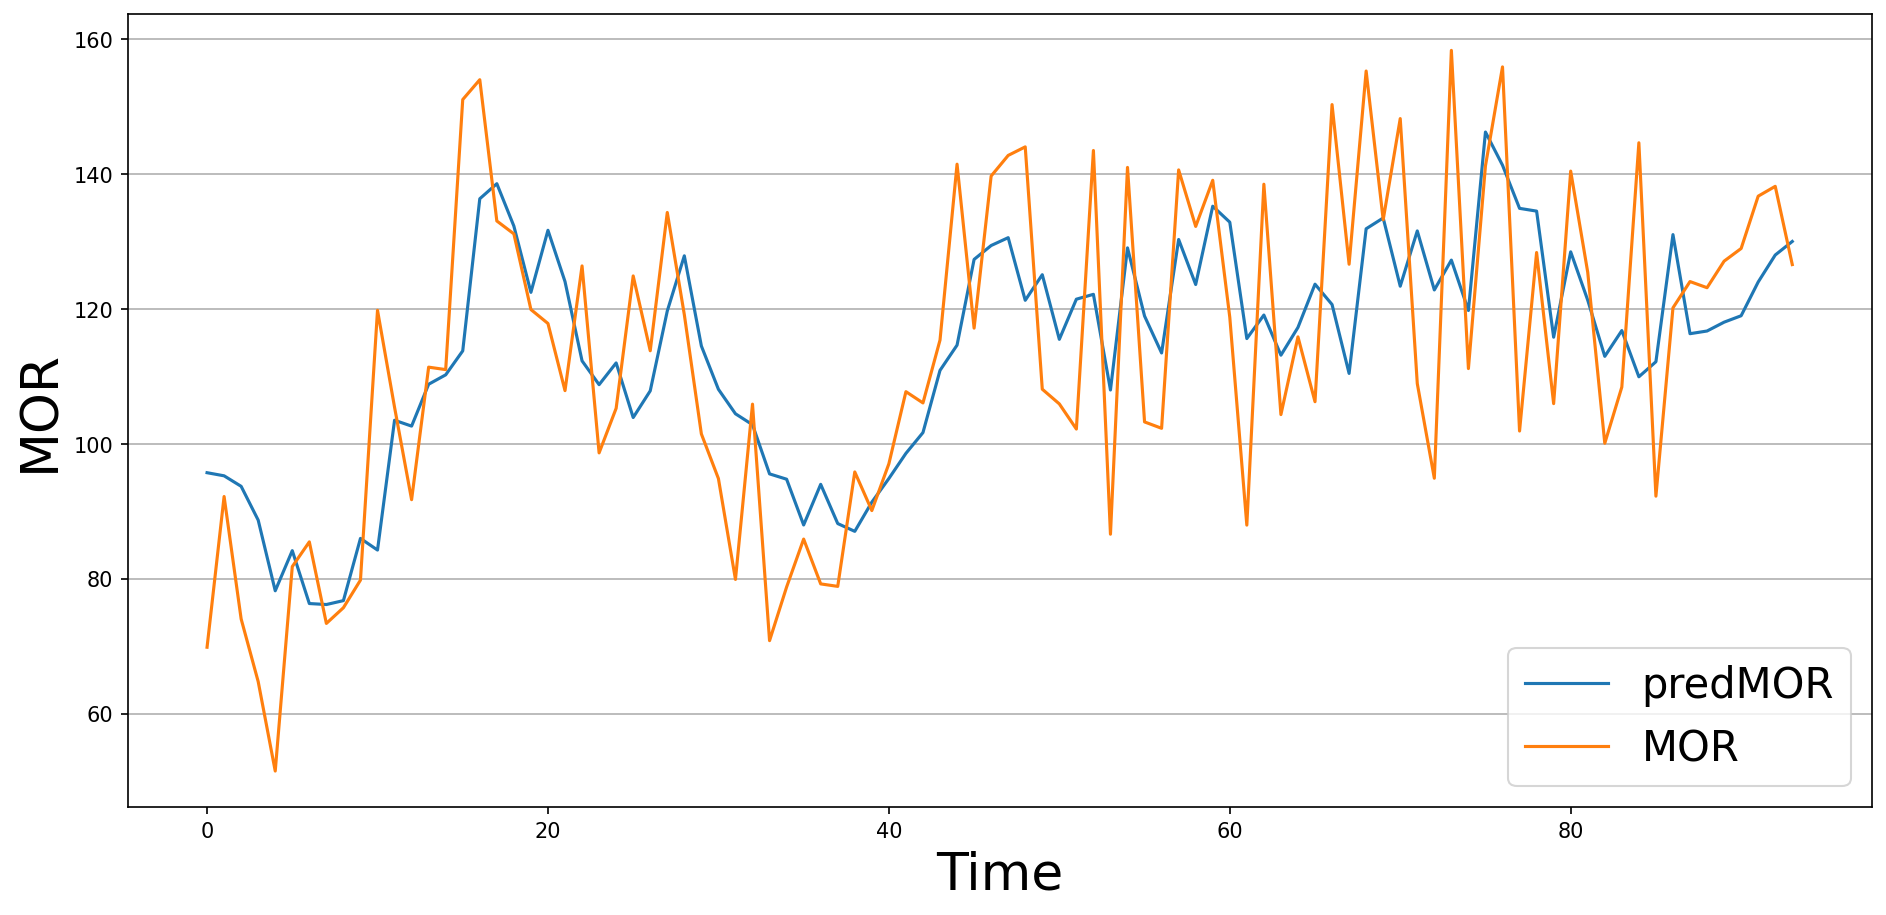

In [233]:
plt.figure(figsize=(15,7), dpi=150)

plt.plot(predTest, label='predMOR')
plt.plot(trainY, label='MOR')

plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=25)
plt.ylabel("MOR",fontsize=25)
plt.grid(which='major', axis='y')
plt.savefig('./predict.jpg', bbox_inches='tight')
plt.show()

In [234]:
train = [127.07329,
        128.954  ,
        136.70454,
        138.16225,
        140.567375]
# train = np.array(train).squeeze()

step = 50
predval = []
for i in range(step):
    da = np.array(train)
    da = np.reshape(train, (1, 5, 1))
    predval.append(model.predict(da)[0][0])
    train = train[1:]
    train.append(predval[i])

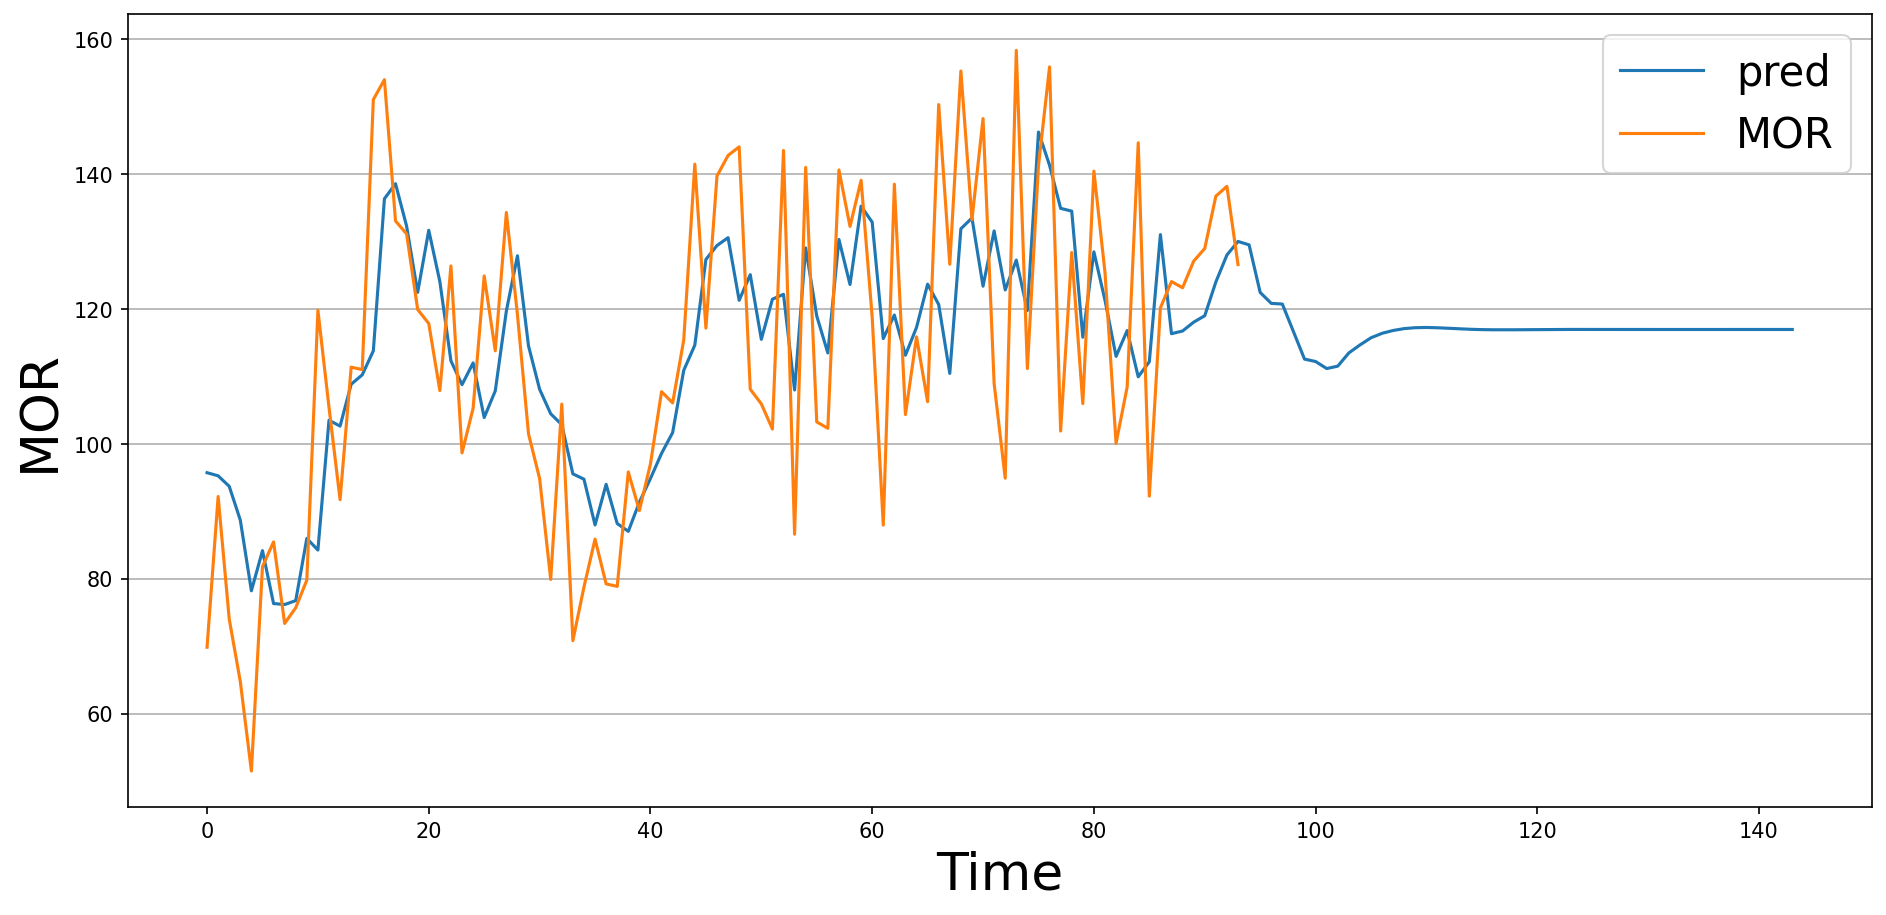

In [265]:
allda = predTest + predval



In [270]:
len(dataMake)

25

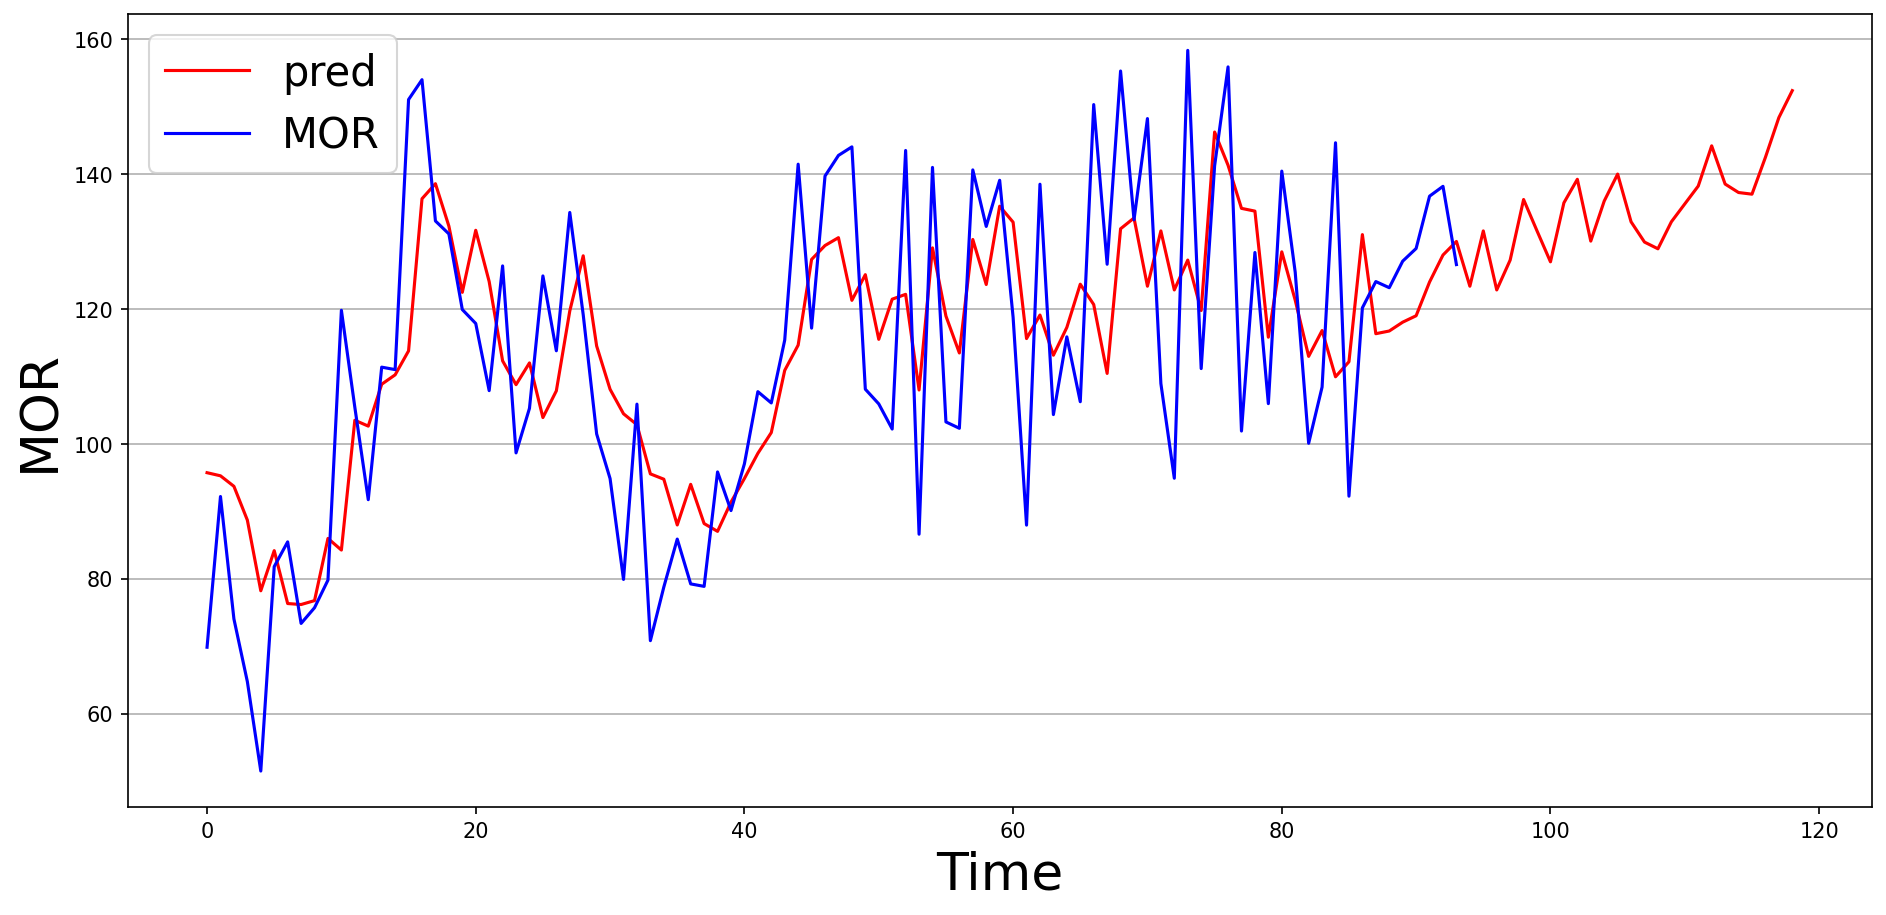

In [268]:
dataMake = [123.36168, 131.5557, 122.810135, 127.23295, 136.20781, 131.5557, 126.97633, 135.7178192138672, 
            139.2027359008789, 130.04456, 135.97633, 139.97633, 132.906105, 129.90058, 128.90713, 132.90713,
            135.55912017822266, 138.2027359008789, 144.16255950927734, 138.502735, 137.245, 137, 142.4564, 
            148.345, 152.345]

plt.figure(figsize=(15,7), dpi=150)

plt.plot(predTest + dataMake, label='pred', color='red')
plt.plot(trainY, label='MOR', color='blue')

plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=25)
plt.ylabel("MOR",fontsize=25)
plt.grid(which='major', axis='y')
plt.savefig('./predict.jpg', bbox_inches='tight')
plt.show()


In [264]:
len(dataMake)

25

In [206]:
predval[5:10] + 20

[112.55912, 112.202736, 111.16256, 111.51852, 113.4787]

In [213]:
def change(pre, st, ed, num):
    for i in range(st, ed):
        pre[i] += num
    
change(predval, 2, 5, 15)


In [217]:
change(predval, 5, 10, 20)


In [218]:
predval[:10]

[129.48831,
 122.43737,
 135.81908416748047,
 135.7178192138672,
 131.63483428955078,
 132.55912017822266,
 132.2027359008789,
 131.16255950927734,
 131.51851654052734,
 133.47869873046875]

In [219]:
predval[10:30]

[114.65414,
 115.719986,
 116.38448,
 116.80294,
 117.08202,
 117.21334,
 117.24824,
 117.20269,
 117.12661,
 117.04456,
 116.97633,
 116.92985,
 116.906105,
 116.90058,
 116.90713,
 116.91951,
 116.932884,
 116.94413,
 116.95187,
 116.955956]

In [220]:
change(predval, 10, 18, 10)

In [221]:
predval[:30]

[129.48831,
 122.43737,
 135.81908416748047,
 135.7178192138672,
 131.63483428955078,
 132.55912017822266,
 132.2027359008789,
 131.16255950927734,
 131.51851654052734,
 133.47869873046875,
 124.65413665771484,
 125.71998596191406,
 126.38448333740234,
 126.80294036865234,
 127.08202362060547,
 127.21334075927734,
 127.24823760986328,
 127.20269012451172,
 117.12661,
 117.04456,
 116.97633,
 116.92985,
 116.906105,
 116.90058,
 116.90713,
 116.91951,
 116.932884,
 116.94413,
 116.95187,
 116.955956]

In [222]:
change(predval, 18, 23, 20)

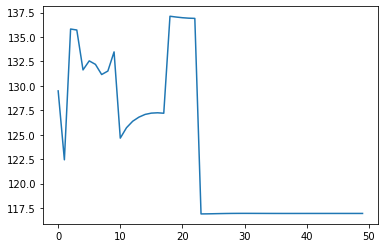

In [223]:
plt.plot(predval)

In [229]:
predTest.append(predval[:23])


76

In [231]:
predTest[80:]

[128.45546,
 121.291756,
 112.96546,
 116.78974,
 109.93932,
 112.17064,
 131.00903,
 116.325676,
 116.7235,
 118.032486,
 118.98555,
 123.98506,
 127.98424,
 129.99513,
 [129.48831,
  122.43737,
  135.81908416748047,
  135.7178192138672,
  131.63483428955078,
  132.55912017822266,
  132.2027359008789,
  131.16255950927734,
  131.51851654052734,
  133.47869873046875,
  124.65413665771484,
  125.71998596191406,
  126.38448333740234,
  126.80294036865234,
  127.08202362060547,
  127.21334075927734,
  127.24823760986328,
  127.20269012451172,
  137.1266098022461,
  137.04456329345703,
  136.97633361816406,
  136.92984771728516,
  136.9061050415039],
 [129.48831,
  122.43737,
  135.81908416748047,
  135.7178192138672,
  131.63483428955078,
  132.55912017822266,
  132.2027359008789,
  131.16255950927734,
  131.51851654052734,
  133.47869873046875,
  124.65413665771484,
  125.71998596191406,
  126.38448333740234,
  126.80294036865234,
  127.08202362060547,
  127.21334075927734,
  127.2482376

In [246]:
predTest

[95.726654,
 95.265495,
 93.70861,
 88.699844,
 78.22944,
 84.17531,
 76.33777,
 76.19265,
 76.77164,
 85.9892,
 84.26382,
 103.49941,
 102.63031,
 108.83599,
 110.22913,
 113.78157,
 136.32166,
 138.55386,
 132.27266,
 122.453,
 131.64966,
 124.04827,
 112.30267,
 108.77257,
 111.993904,
 103.90076,
 107.856476,
 119.68883,
 127.867935,
 114.503914,
 108.08751,
 104.45826,
 102.8374,
 95.55067,
 94.7637,
 87.98242,
 94.001884,
 88.188965,
 87.03552,
 91.362274,
 94.86597,
 98.5934,
 101.673065,
 110.88771,
 114.63021,
 127.33233,
 129.39159,
 130.55486,
 121.27085,
 125.0701,
 115.49034,
 121.4391,
 122.157646,
 107.9814,
 129.04369,
 118.94173,
 113.470055,
 130.28645,
 123.61393,
 135.21898,
 132.85034,
 115.60444,
 119.090744,
 113.1395,
 117.254654,
 123.66284,
 120.647865,
 110.437325,
 131.87178,
 133.4706,
 123.36168,
 131.5557,
 122.810135,
 127.23295,
 119.76304,
 146.20781,
 141.29062,
 134.89862,
 134.48972,
 115.80564,
 128.45546,
 121.291756,
 112.96546,
 116.78974,
 109.

In [248]:
predval

[129.48831,
 122.43737,
 120.819084,
 120.71782,
 116.634834,
 112.55912,
 112.202736,
 111.16256,
 111.51852,
 113.4787,
 114.65414,
 115.719986,
 116.38448,
 116.80294,
 117.08202,
 117.21334,
 117.24824,
 117.20269,
 117.12661,
 117.04456,
 116.97633,
 116.92985,
 116.906105,
 116.90058,
 116.90713,
 116.91951,
 116.932884,
 116.94413,
 116.95187,
 116.955956,
 116.95701,
 116.95607,
 116.95413,
 116.95198,
 116.950134,
 116.94884,
 116.94814,
 116.94795,
 116.94809,
 116.948395,
 116.948746,
 116.94904,
 116.94925,
 116.94936,
 116.949394,
 116.94939,
 116.94934,
 116.94929,
 116.94923,
 116.94921]